LSTM

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras import optimizers

from sklearn.metrics import mean_squared_error

In [16]:
df = pd.read_csv('clean_train.csv', 
                 parse_dates={'dt' : ['pickup_datetime']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt',nrows=2000000)

In [17]:
df.describe

<bound method NDFrame.describe of                            fare_amount  pickup_longitude  pickup_latitude  \
dt                                                                          
2009-06-15 17:26:21+00:00          4.5        -73.844311        40.721319   
2010-01-05 16:52:16+00:00         16.9        -74.016048        40.711303   
2011-08-18 00:35:00+00:00          5.7        -73.982738        40.761270   
2012-04-21 04:30:42+00:00          7.7        -73.987130        40.733143   
2010-03-09 07:51:00+00:00          5.3        -73.968095        40.768008   
...                                ...               ...              ...   
2014-10-09 11:57:07+00:00         14.0        -74.010142        40.720534   
2009-07-27 19:37:01+00:00          6.5        -73.965706        40.759476   
2010-01-23 16:09:00+00:00          6.1        -73.981353        40.758682   
2010-06-23 19:11:41+00:00          6.5        -73.988788        40.736638   
2010-12-28 01:00:43+00:00          4.1    

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:

values = df.values
values = values.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[7,8,9,10,11]],axis=1,inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.0090,0.406069,0.184886,0.391800,0.174736,0.111111,0.0338
2,0.0338,0.298003,0.176517,0.307531,0.232143,0.111111,0.0114
3,0.0114,0.318963,0.218268,0.300200,0.206256,0.222222,0.0154
4,0.0154,0.316200,0.194766,0.300002,0.212456,0.111111,0.0106
5,0.0106,0.328177,0.223898,0.321373,0.233591,0.111111,0.0242


In [20]:
values=reframed.values
print(values.shape)

(1048574, 7)


In [21]:
train = values[:1000000,:]
test= values[1000000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
print(train_y[1])

(1000000, 1, 6) (1000000,) (48574, 1, 6) (48574,)
0.0114


In [22]:
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=[rmse])

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
history = model.fit(train_X, train_y, epochs=80, batch_size=7000, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 1000000 samples, validate on 48574 samples
Epoch 1/80
 - 3s - loss: 5.3894e-04 - rmse: 0.0155 - val_loss: 3.6688e-04 - val_rmse: 0.0120
Epoch 2/80
 - 3s - loss: 4.0335e-04 - rmse: 0.0127 - val_loss: 3.6629e-04 - val_rmse: 0.0120
Epoch 3/80
 - 4s - loss: 3.8887e-04 - rmse: 0.0123 - val_loss: 3.6585e-04 - val_rmse: 0.0119
Epoch 4/80
 - 4s - loss: 3.8465e-04 - rmse: 0.0122 - val_loss: 3.6553e-04 - val_rmse: 0.0119
Epoch 5/80
 - 4s - loss: 3.8300e-04 - rmse: 0.0121 - val_loss: 3.6528e-04 - val_rmse: 0.0119
Epoch 6/80
 - 4s - loss: 3.8199e-04 - rmse: 0.0121 - val_loss: 3.6507e-04 - val_rmse: 0.0119
Epoch 7/80
 - 4s - loss: 3.8132e-04 - rmse: 0.0121 - val_loss: 3.6494e-04 - val_rmse: 0.0119
Epoch 8/80
 - 4s - loss: 3.8063e-04 - rmse: 0.0121 - val_loss: 3.6484e-04 - val_rmse: 0.0119
Epoch 9/80
 - 4s - loss: 3.8002e-04 - rmse: 0.0121 - val_loss: 3.6477e-04 - val_rmse: 0.0119
Epoch 10/80
 - 4s - loss: 3.7961e-04 - rmse: 0.0121 - val_loss:

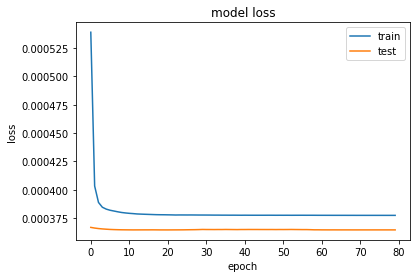

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
ypred = model.predict(test_x)
print(ypred)

[[0.02253107]
 [0.02251942]
 [0.02253432]
 ...
 [0.02250689]
 [0.02252303]
 [0.02250643]]


In [26]:
rmse = np.sqrt(mean_squared_error(test_y,ypred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.019


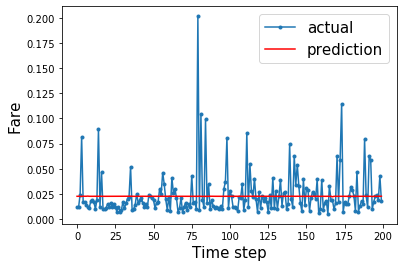

In [29]:
aa=[x for x in range(200)]
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, ypred[:200], 'r', label="prediction")
plt.ylabel('Fare', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Reference:
### https://colah.github.io/posts/2015-08-Understanding-LSTMs/
### https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/    
### https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
